In [1]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
from scipy import stats 
import IS as isfn
import network_mod as netfn

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

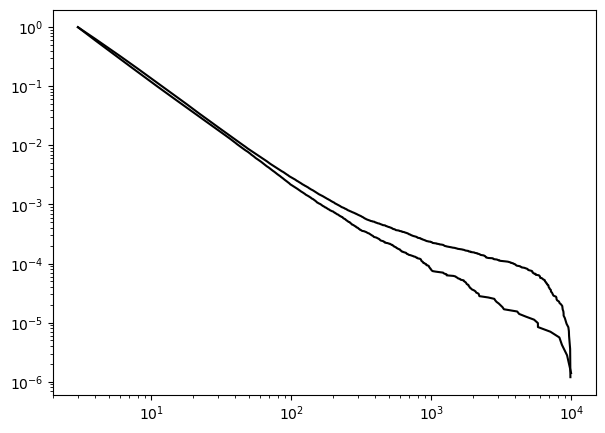

In [2]:
# Choose path and create lists of coord and trace files

# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))

choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i][bln_distlist[i] <= 10000])
    p20_vec = np.append(p20_vec, p20_distlist[i][p20_distlist[i] <= 10000])
    
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k')
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k')

plt.show()

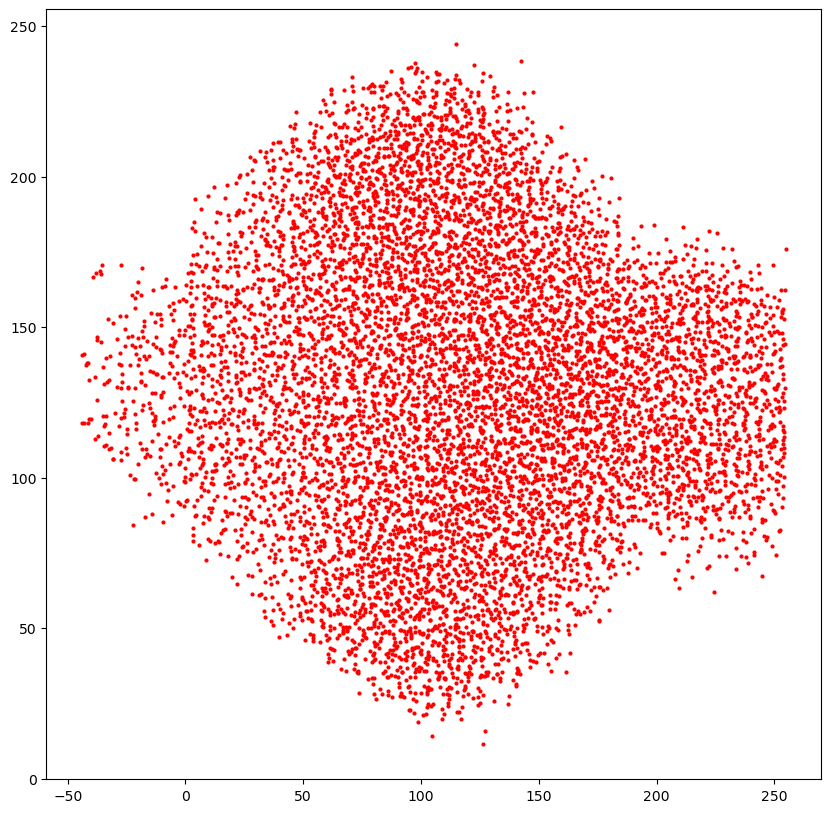

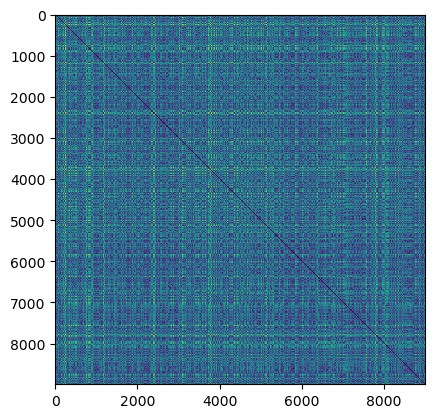

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)

node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()


In [4]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

38787

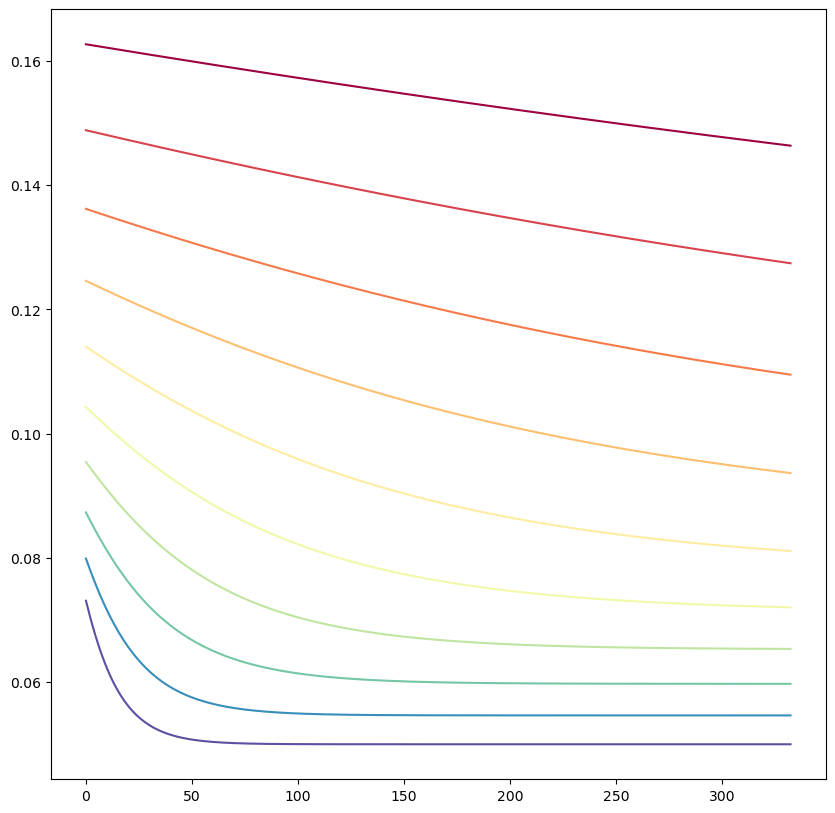

In [86]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 10
divisor = 10
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()



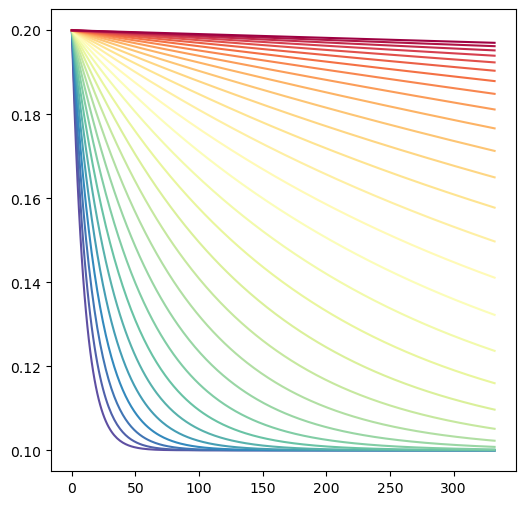

In [5]:
#Two parameters - one for scaling (s) + one for relaxing (r)
# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, r,s):
    edgeweights = (s + np.exp(-soften/np.exp(r)*distance))/divisor
    return edgeweights

#S parameters
Nsteps  = 30
divisor = 10
soften = 0.1
s = 1
r_vals   = np.array(np.linspace(0, 7, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(6,6))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for r in range(len(r_vals)):
    ax.plot(distance, dist2edge(distance, divisor, r_vals[r], s), c=colors[r])
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [6]:
#Build nearest neighbour matrix for model
#nnb = crfn.neighbour_r(nodes, 0.16, 6000, [1, 1, 1])
#np.save('net_model_nnb.npy', nnb)

experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
net_nnb = np.load(sorted(glob.glob('*net_model_nnb*'))[0])
net_nnb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

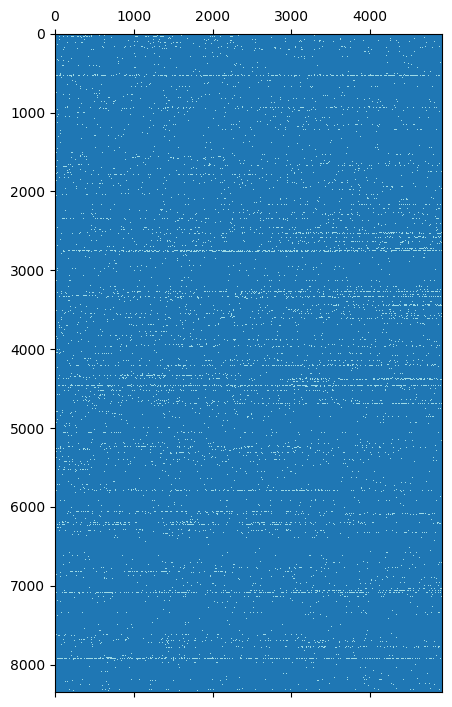

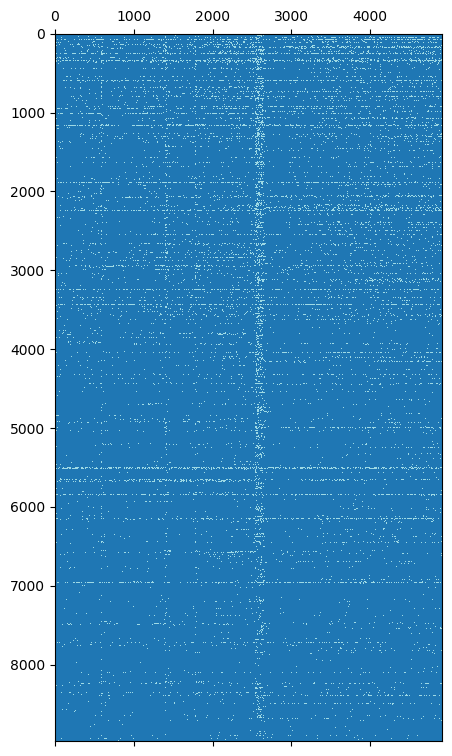

In [3]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
bln_bin = sorted(glob.glob('*-02*BLN*0.590*binarised.npy*')) #iterated list - binarised trace
ptz_bin = sorted(glob.glob('*-02*PTZ20*0.590*binarised.npy*')) #iterated list - binarised trace

fig, ax = plt.subplots(figsize= (5,10))
ax.matshow(np.load(bln_bin[0]), cmap = 'tab20')
plt.show()
fig, ax = plt.subplots(figsize= (5,10))
ax.matshow(np.load(ptz_bin[0]), cmap = 'tab20')
plt.show()

# Single LIF neuron

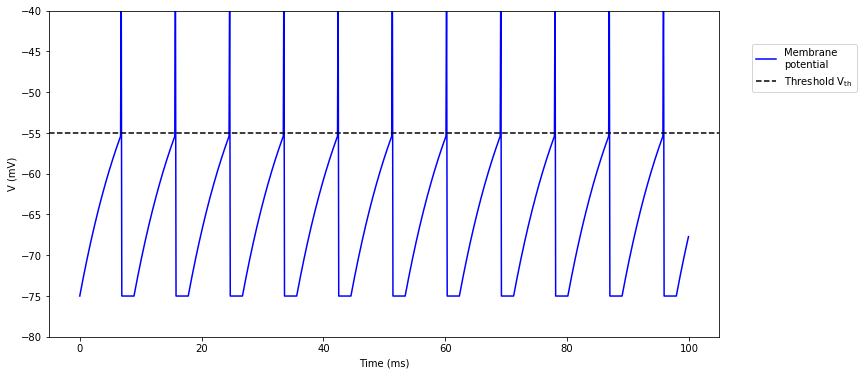

In [20]:
#LIF NEURON

#set parameters
t = 100 #simulation time
dt = 0.1 #time step
t_bins = np.arange(0, t, dt) #time bins
t_ref = 2 #refractory period
tau_m = 10 # membrane time constant - time taken to decay to 36% of max value = capacitence / leak

v_init = -75  #initial voltage
v_reset = -75 #reset voltage after spike
v_rest = -75 #equilibrium potential - resting potential

v_th = -55  #voltage spike threshold
g_L = 10 #leak 

I = 400 #input current

# Initialize voltage 
v_vec = np.zeros(len(t_bins)) #voltage values over time
v_vec[0] = v_init #voltage at time 0

# Initialize current
I = I * np.ones(len(t_bins)) #constant injected current 


# Simulate 
spike_vec = []  # record spike times
t_ref_count = 0  # the count for refractory duration

#loop through each time step
for it in range(len(t_bins) - 1):
    if t_ref_count > 0:  # check for refractoriness
        v_vec[it] = v_reset
        t_ref_count = t_ref_count - 1 #iterate until t_ref_count = 0
        
    elif v_vec[it] >= v_th:  # reset voltage and record spike event
        spike_vec.append(it)
        v_vec[it] = v_reset
        t_ref_count = t_ref / dt #convert refractory time to bins

    # calculate the increment of the membrane potential
    dv = (-1*(v_vec[it] - v_rest) + I[it] / g_L) * dt/tau_m

    # update the membrane potential
    v_vec[it+1] = v_vec[it] + dv

spike_vec = np.array(spike_vec) * dt #convert into time bins

if spike_vec.size:
    sp_num = (spike_vec / dt).astype(int) - 1
    v_vec[sp_num] += 20  # draw nicer spikes

plt.plot(t_bins, v_vec, 'b')
plt.axhline(v_th, 0, 1, color='k', ls='--')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
         loc=[1.05, 0.75])
plt.ylim([-80, -40])
plt.show()

# Spiking network

## Python implementation

In [22]:
#Define net parameters
#=============================
runtime = 100 #ms
n_size = 500

net = dict()
net['weights'] = np.random.uniform(0, 1, size=(n_size, n_size)) #for neuron i (row) = weight of neuron i onto neuron j
net['delays'] = np.random.randint(11, size=(n_size, n_size)) #for neuron i (row) = delay of neuron i onto neuron j

#Define LIF parameters
#=============================
t_ref = 2 #refractory period in ms
dt = 0.1 #time step
tau_m = 10 # membrane time constant - time taken to decay to 36% of max value = capacitence / leak

v_init = -75  #initial voltage
v_reset = -75 #reset voltage after spike
v_rest = -75 #equilibrium potential - resting potential
v_th = -55  #voltage spike threshold
g_L = 1.3 #leak 


#Define later - make dynamic not constant?
#Poisson spike trains 
#random selection of neuron at a given rate, with given step size

inp_current = np.random.randint(2, size=(n_size, runtime), dtype=np.bool)
inp_current = inp_current*50 + (1-inp_current)*5 # units mV

# Initialise voltage + current + spikes
spikes = np.zeros((n_size, runtime))
v = np.ones((n_size, runtime))*v_init

delays_inv = net['delays'].T #delay of neuron j onto neuron i (current neuron of interest)
weights_inv = net['weights'].T #weight of neuron j onto neuron i (current neuron of interest)

#Loop through each time step
for t in range(runtime - 1): 
    
    #Calculate internal current (from other neurons)
    past = t - delays_inv #array with time to look back to - neuron i (row) for all incoming neuron js (columns)
    past[past < 0] = t #reset negative values to current time - no spikes assigned yet
    
    past_spikes = spikes[np.arange(n_size), past] #array of incoming spikes - neuron i (row) for all incoming neuron js (columns)
    int_current = (past_spikes*weights_inv).sum(-1) #internal current - vector sum of incoming weights onto each neuron

    #Calculate external current (from external input)
    ext_current = inp_current[:,t]
    
    #vector of total current
    I = ext_current + int_current

    #Euler's method - stepwise approximate 1ms of activity
    for d in range(int(1/dt)):
        
        #only look at non-firing neurons - if they fire, then they are on for 1 ms so dont need to update
        not_fired = np.where(spikes[:,t] == 0)[0] #indeces for non firing neurons
        
        # calculate the increment of the membrane potential
        v[not_fired, t] += dt/tau_m *(-1*(v[not_fired,t] - v_rest) + (I[not_fired]/ g_L)) 
            
        #add spike when passed threshold
        where_thresh = np.where(v[:,t] >=v_th)[0] #where any spike has occured
        spikes[where_thresh,t]  = 1
        
    v[spikes[:,t] == 1 ,t] = v_reset #change spikes to reset potential for current time frame 
    v[:,t+1] = v[:,t]  #update starting voltage for next time frame
    


In [ ]:
# Refractory period
spike_vec = []  # record spike times
t_ref_count = 0  # the count for refractory duration

#loop through each time step
for it in range(len(t_bins) - 1):
    if t_ref_count > 0:  # check for refractoriness
        v_vec[it] = v_reset
        t_ref_count = t_ref_count - 1 #iterate until t_ref_count = 0
        
    elif v_vec[it] >= v_th:  # reset voltage and record spike event
        spike_vec.append(it)
        v_vec[it] = v_reset
        t_ref_count = t_ref / dt #convert refractory time to bins


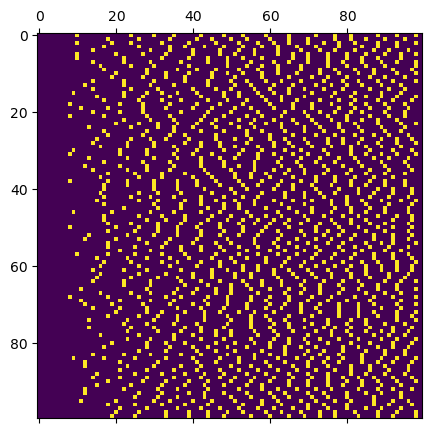

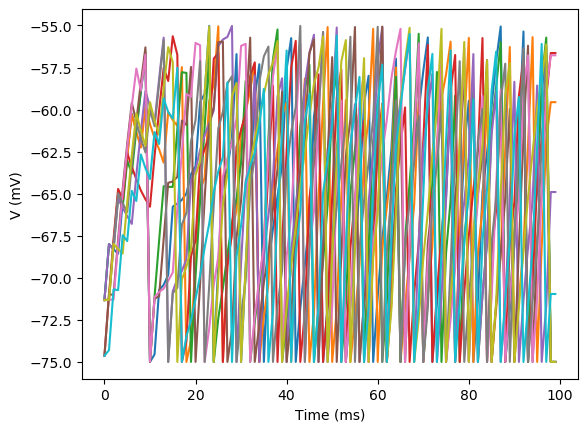

In [27]:
fig, ax = plt.subplots(figsize= (5,5))
ax.matshow(spikes[:100])
plt.show()

for i in range(10):
    plt.plot(v[i])
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
#plt.ylim([-80, -40])
plt.show()

## B2 implementation

In [6]:
import brian2 as b2
%matplotlib inline
from random import sample
from numpy import random

In [12]:
nnb = crfn.neighbour_r(nodes, 0.16, 6000, [1, 1, 1])
np.save('net_model_nnb.npy', nnb)

Doing row 0 of 8990
Doing row 899 of 8990
Doing row 1798 of 8990
Doing row 2697 of 8990
Doing row 3596 of 8990
Doing row 4495 of 8990
Doing row 5394 of 8990
Doing row 6293 of 8990
Doing row 7192 of 8990
Doing row 8091 of 8990


In [438]:
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
net_nnb = np.load(sorted(glob.glob('*net_model_nnb*'))[0])
net_nnb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
import brian2 as b2
from random import sample
from numpy import random

## LIF PARAMETERS
#Network dynamics
N = nodes.shape[0] 
v_rest= 0 #Resting potential
t_syn_del = 1 * b2.ms #delay between presynaptic spike and postsynaptic increase
tau_l = 20. * b2.ms #leak time constant - time taken for voltage to reach 63% of resting value

#External input
N_e = 500 #number of presynaptic excitatory poisson neurons 
lam = 10 * b2.Hz #poisson rate of external population
w_e= 0.1  #synaptic weight of excitatory external possion neurons onto all neurons 

#Bin data function
def bin_data(spikes, N, sim_time):
    bin_dat = np.zeros((N, sim_time))
    for i in range(N):
        bin_dat[i][np.unique((np.asarray(spikes[i])*1000).astype(int))] = 1
    return(bin_dat)

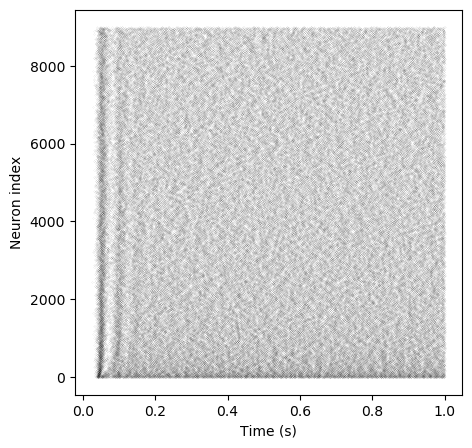

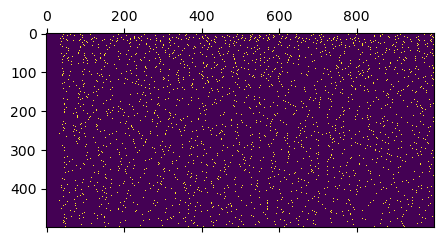

<synapses.w: array([0.06185305, 0.063925  , 0.06322639, ..., 0.06141943, 0.06120702,
       0.06180752])>


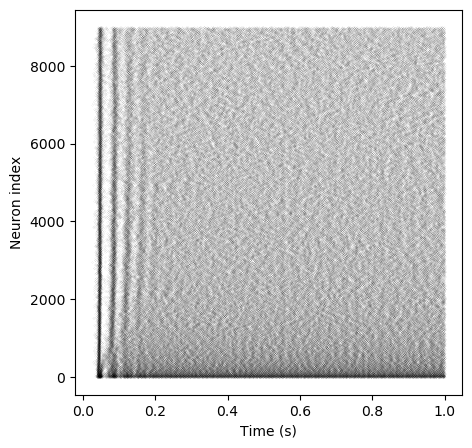

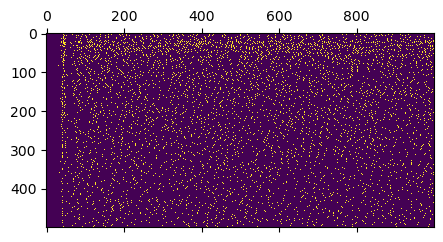

<synapses_2.w: array([0.0621143 , 0.06259892, 0.06119815, ..., 0.06188369, 0.06231949,
       0.07487938])>


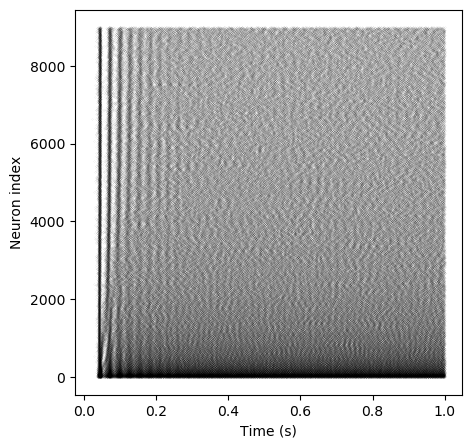

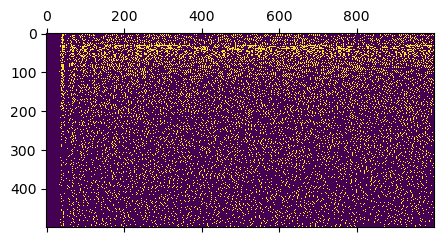

<synapses.w: array([0.06908261, 0.06173765, 0.0612744 , ..., 0.06804511, 0.06432944,
       0.06149775])>


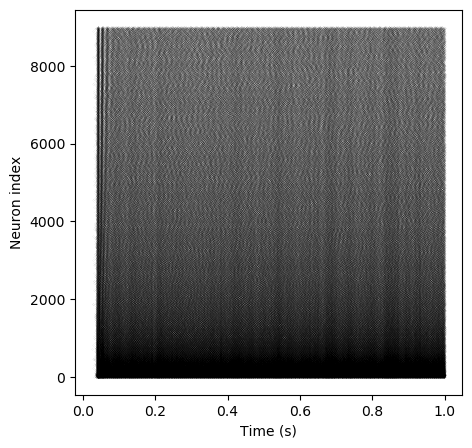

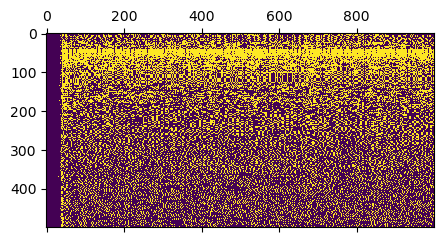

<synapses_2.w: array([0.06117267, 0.06264196, 0.06306   , ..., 0.06274295, 0.06122791,
       0.0794779 ])>


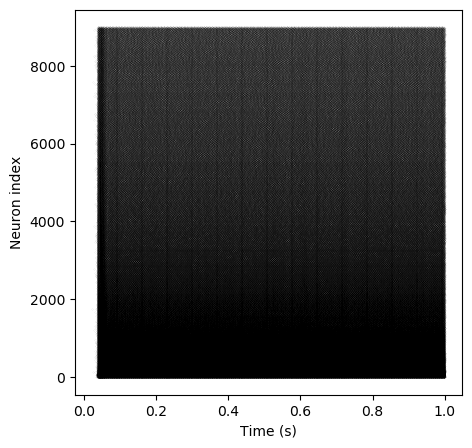

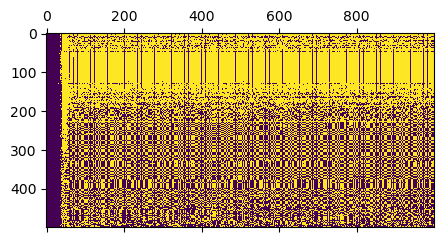

<synapses.w: array([0.06121982, 0.06165725, 0.06509002, ..., 0.06526077, 0.06340071,
       0.06429815])>


In [90]:
#Parameters
s = 1 #edge weight
r = 0 #relax parameter
v_th = 10 #spike threshold

k_vals = [10, 20, 30, 40, 50]
#k_vals = [50, 70, 100]
for i in k_vals:

    sim_time=1000 #ms - 10 time steps per ms
    b2.start_scope()


    # define dynamics for each cell
    lif ="""
        dv/dt = -(v-v_rest) / tau_l : 1 """
    net_dyn = b2.NeuronGroup(
        N, model=lif,
        threshold="v>v_th", reset="v = v_rest",
        method="euler")
    net_dyn.v = v_rest #set starting value for voltage

    p_input = b2.PoissonInput(net_dyn, "v", N_e,lam, w_e)

    #Network connectivity + weights

    #curr = netfn.ba_netsim(dist).adjmat_generate(i, s, r, divisor, soften, 'directed')
    curr = ba1_netsim(dist).adjmat_generate(i, s, divisor, soften, 'undirected')
    #curr = ba1_netsim(dist).adjmat_generate(s, p, i, divisor, soften)
    A = curr.A
    W = curr.adj_mat

    #Build synapses
    net_syn = b2.Synapses(net_dyn, net_dyn, 'w:1', on_pre="v+=w", delay=t_syn_del)
    rows, cols = np.nonzero(A)
    net_syn.connect(i = rows, j = cols)
    net_syn.w = W[rows, cols]

    spike_monitor = b2.SpikeMonitor(net_dyn)
    V = b2.StateMonitor(net_dyn, 'v', record=True)
    b2.run(sim_time*b2.ms)
    spikes = spike_monitor.spike_trains()
    volt = np.asarray(V.v)

    #Plot data
    fig, axarr = plt.subplots(figsize = (5,5))
    plt.plot(spike_monitor.t, spike_monitor.i, '.k', markersize = 0.05)
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index');
    plt.show()

    bind = bin_data(spikes, N, sim_time)
    fig, ax = plt.subplots(figsize= (5,15))
    ax.matshow(bind[:500])
    plt.show()
    print(net_syn.w)



In [65]:
## LIF PARAMETERS

#Network dynamics
v_rest= 0 #Resting potential
v_th = 10 #Spike threshold
t_syn_del = 1 * b2.ms #delay between presynaptic spike and postsynaptic increase
tau_l = 20. * b2.ms #leak time constant - time taken for voltage to reach 63% of resting value

#External input
N_e = 500 #number of presynaptic excitatory poisson neurons 
lam = 10. * b2.Hz #poisson rate of external population
w_e= 0.1  #synaptic weight of excitatory external possion neurons onto all neurons 

#Bin data function
def bin_data(spikes, N, sim_time):
    bin_dat = np.zeros((N, sim_time))
    for i in range(N):
        bin_dat[i][np.unique((np.asarray(spikes[i])*1000).astype(int))] = 1
    return(bin_dat)

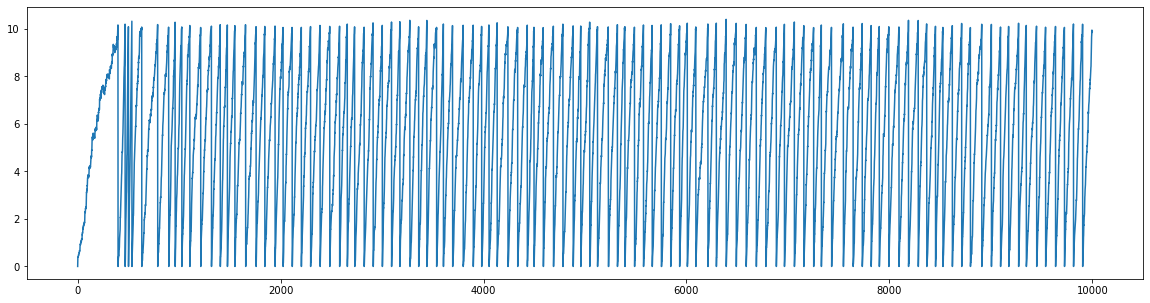

In [436]:
fig, axarr = plt.subplots(figsize = (20,5))                   
axarr.plot(volt[0])
plt.show()

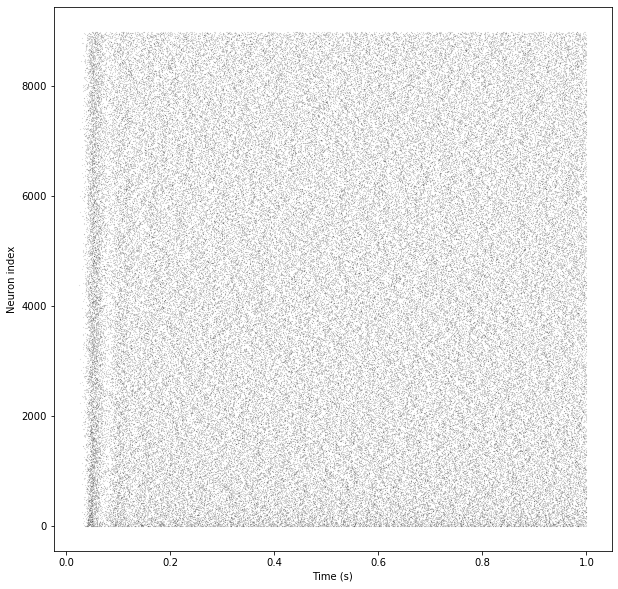

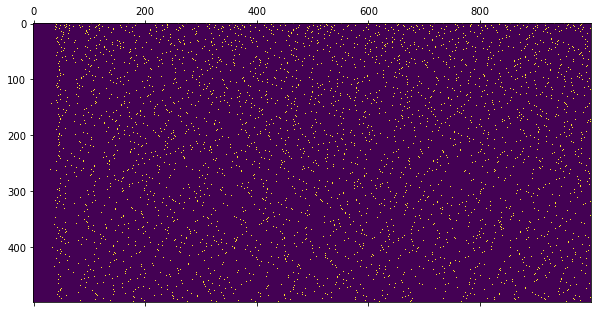

In [437]:
sim_time=1000 #ms - 10 time steps per ms
b2.start_scope()

# define dynamics for each cell
lif ="""
    dv/dt = -(v-v_rest) / tau_l : 1 """
net_dyn = b2.NeuronGroup(
    N, model=lif,
    threshold="v>v_th", reset="v = v_rest",
    method="euler")
net_dyn.v = v_rest #set starting value for voltage

p_input = b2.PoissonInput(net_dyn, "v", N_e,lam, w_e)

#Network connectivity + weights
s = 0
k = 5
p = 0.3
curr = bap_netsim(dist).adjmat_generate(s, p, k, divisor, soften)
A = curr.A
W = curr.adj_mat

#Build synapses
net_syn = b2.Synapses(net_dyn, net_dyn, 'w:1', on_pre="v+=w", delay=t_syn_del)
rows, cols = np.nonzero(A)
net_syn.connect(i = rows, j = cols)
net_syn.w = W[rows, cols]

spike_monitor = b2.SpikeMonitor(net_dyn)
V = b2.StateMonitor(net_dyn, 'v', record=True)
b2.run(sim_time*b2.ms)
spikes = spike_monitor.spike_trains()
volt = np.asarray(V.v)

#Plot data
fig, axarr = plt.subplots(figsize = (10,10))
plt.plot(spike_monitor.t, spike_monitor.i, '.k', markersize = 0.1)
plt.xlabel('Time (s)')
plt.ylabel('Neuron index');
plt.show()

bind = bin_data(spikes, N, sim_time)
fig, ax = plt.subplots(figsize= (10,30))
ax.matshow(bind[:500])
plt.show()



In [440]:
ok = crfn.avalanche_r(net_nnb, bind)

doing time step 0of1000for fish 
doing time step 100of1000for fish 
doing time step 200of1000for fish 
doing time step 300of1000for fish 
doing time step 400of1000for fish 
doing time step 500of1000for fish 
doing time step 600of1000for fish 
doing time step 700of1000for fish 
doing time step 800of1000for fish 
doing time step 900of1000for fish 


WARNING    /Users/dominicburrows/Dropbox/PhD/Analysis/py_scripts/suite2p_analysis_py/avalanches.py:267: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  avframescut = framesvec[[avsize >=3]]
 [py.warnings]


In [443]:
ok

array([[3, 3, 3, ..., 3, 3, 4],
       [1, 1, 1, ..., 1, 1, 1]])

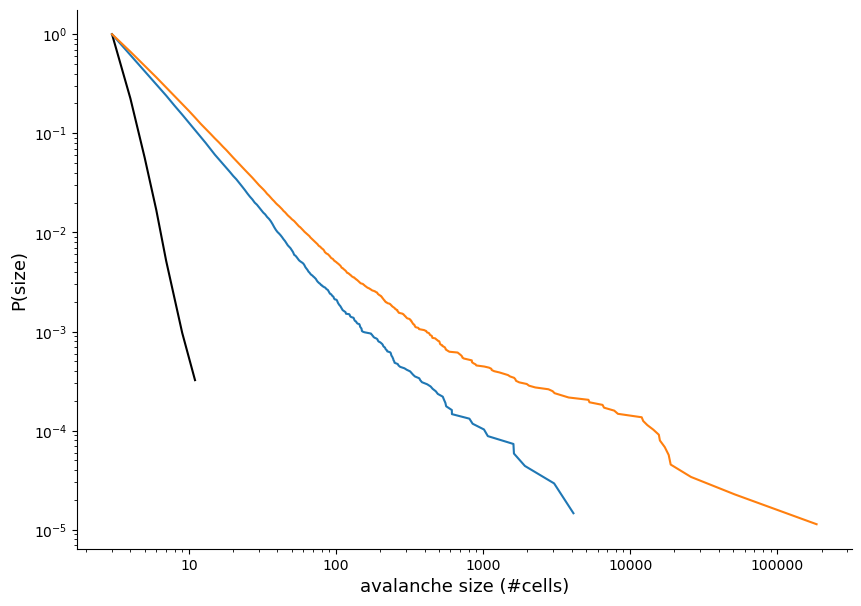

In [445]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (10,7))
sns.reset_orig()

powerlaw.plot_ccdf(ok[0], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k') 
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)


axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
import matplotlib
import powerlaw

colors  = cm.coolwarm(np.linspace(0,1,len(k_av_list)))
fig, axarr = plt.subplots(figsize = (10,7))
sns.reset_orig()

for i in range(len(k_av_list)):
    avdistcut = k_av_list[i][0]
    powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i]) 

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
k_av_list = list(range(len(k_bind_list)))
for i in range(len(k_bind_list)):
    k_av_list[i] = avalanche(nnb, k_bind_list[i])

<synapses.w: array([0.05000002, 0.05000253, 0.05000085, ..., 0.05000939, 0.05000001,
       0.05000006])>


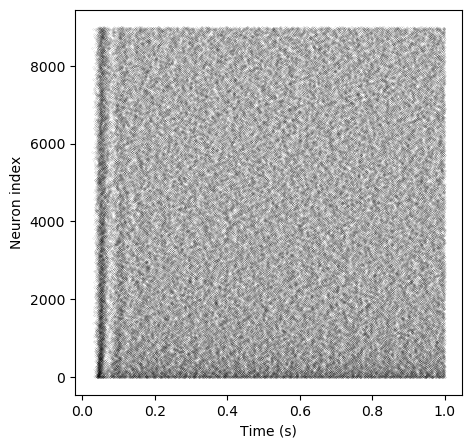

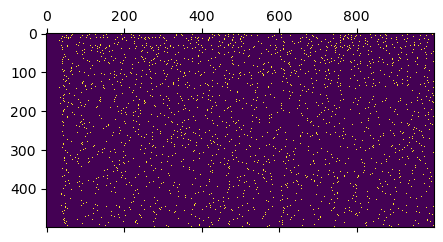

<synapses_1.w: array([0.08002023, 0.0852558 , 0.08380796, ..., 0.08438824, 0.07864151,
       0.08807756])>


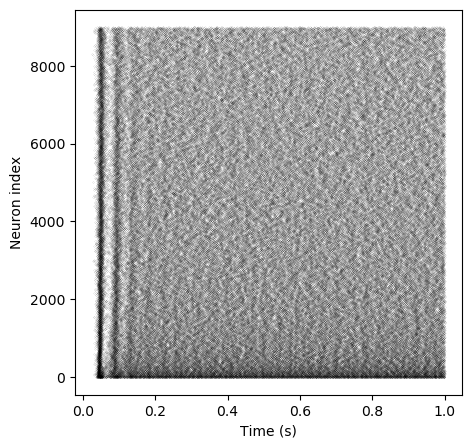

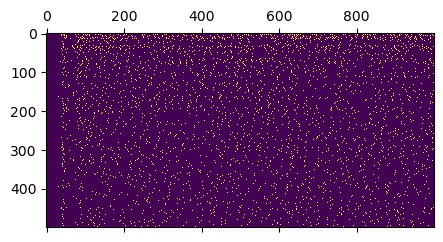

<synapses.w: array([0.15214992, 0.15567711, 0.15489248, ..., 0.15594007, 0.14853209,
       0.15114625])>


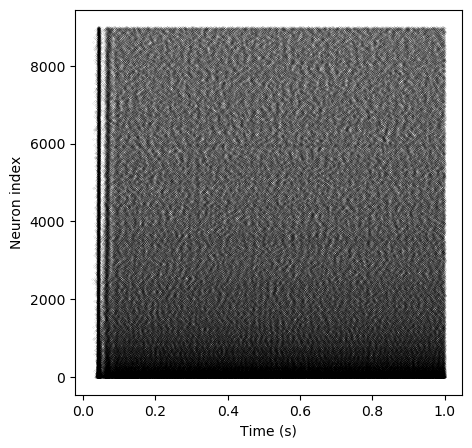

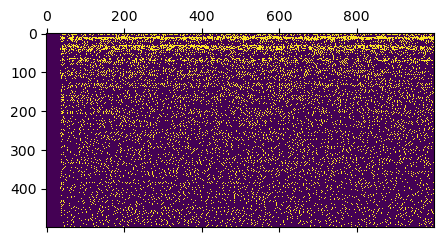

<synapses_1.w: array([0.24044014, 0.24124059, 0.24106637, ..., 0.24005037, 0.24051246,
       0.240186  ])>


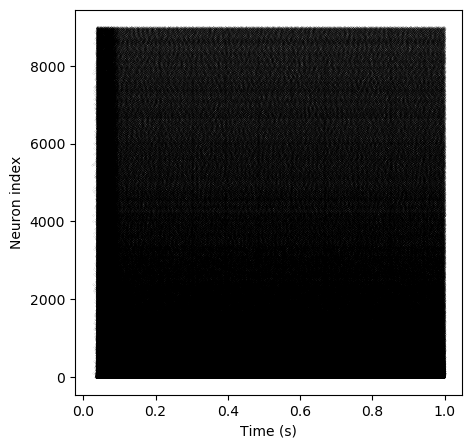

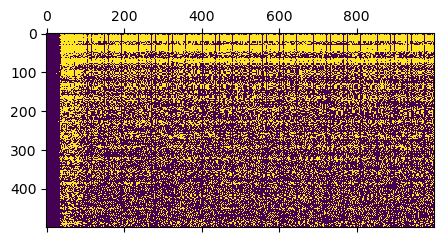

In [69]:
sim_time=1000 #ms - 10 time steps per ms
b2.start_scope()

s_vals = [0, 2, 4, 6]
count=0

for i in (s_vals):

    sim_time=1000 #ms - 10 time steps per ms
    b2.start_scope()

    # define dynamics for each cell
    lif ="""
        dv/dt = -(v-v_rest) / tau_l : 1 """
    net_dyn = b2.NeuronGroup(
        N, model=lif,
        threshold="v>v_th", reset="v = v_rest",
        method="euler")
    net_dyn.v = v_rest #set starting value for voltage

    p_input = b2.PoissonInput(net_dyn, "v", N_e,lam, w_e)

    #Network connectivity + weights
    s = i
    k = 10
    p = 0.3
    curr = bap_netsim(dist).adjmat_generate(s, p, k, divisor, soften)
    A = curr.A
    W = curr.adj_mat

    #Build synapses
    net_syn = b2.Synapses(net_dyn, net_dyn, 'w:1', on_pre="v+=w", delay=t_syn_del)
    rows, cols = np.nonzero(A)
    net_syn.connect(i = rows, j = cols)
    net_syn.w = W[rows, cols]

    spike_monitor = b2.SpikeMonitor(net_dyn)
    V = b2.StateMonitor(net_dyn, 'v', record=True)
    b2.run(sim_time*b2.ms)
    spikes = spike_monitor.spike_trains()
    volt = np.asarray(V.v)
    print(net_syn.w)

    #Plot data
    fig, axarr = plt.subplots(figsize = (5,5))
    plt.plot(spike_monitor.t, spike_monitor.i, '.k', markersize = 0.1)
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index');
    plt.show()

    bind = bin_data(spikes, N, sim_time)
    fig, ax = plt.subplots(figsize= (5,5))
    ax.matshow(bind[:500])
    plt.show()

<synapses_1.w: array([0.05000157, 0.05000035, 0.0500017 , ..., 0.05      , 0.05      ,
       0.0500009 ])>


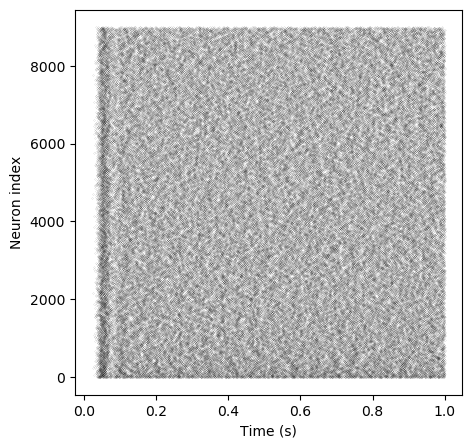

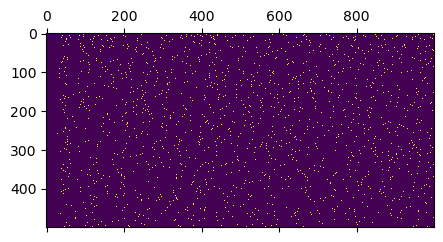

<synapses.w: array([0.05000002, 0.05000085, 0.05      , ..., 0.05      , 0.05000501,
       0.05      ])>


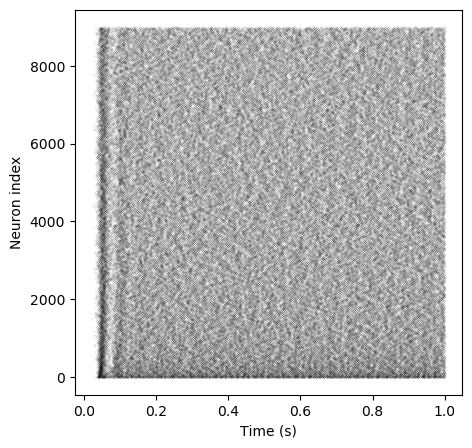

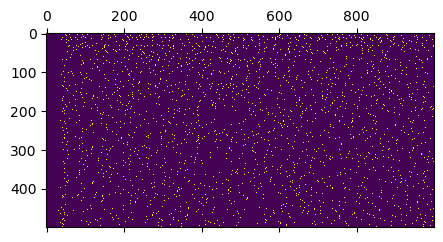

<synapses_1.w: array([0.05000072, 0.05      , 0.05      , ..., 0.05      , 0.0500043 ,
       0.05      ])>


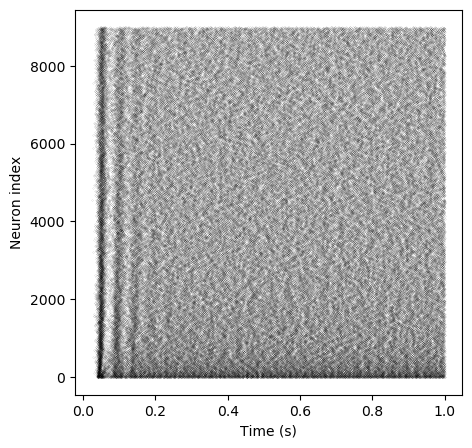

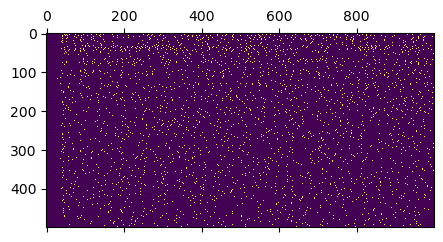

<synapses.w: array([0.05000005, 0.05      , 0.05000006, ..., 0.05      , 0.05003505,
       0.05000001])>


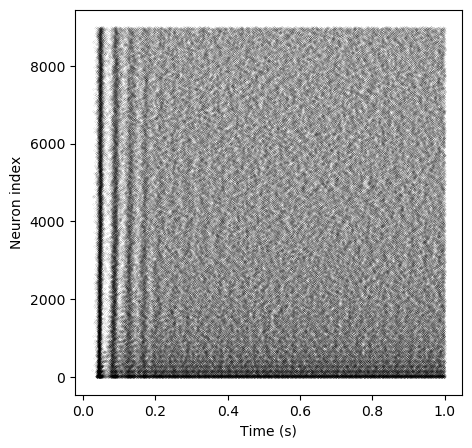

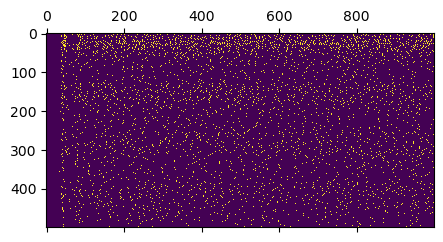

<synapses_1.w: array([0.05008674, 0.05000001, 0.05000016, ..., 0.05000001, 0.05000007,
       0.05000003])>


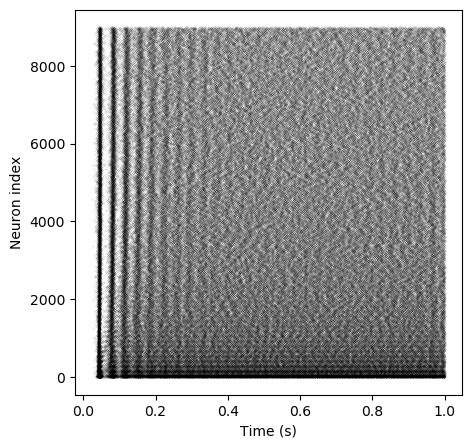

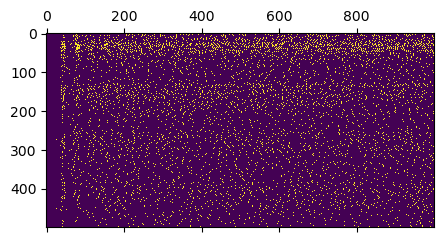

In [71]:
sim_time=1000 #ms - 10 time steps per ms
b2.start_scope()

k_vals = [5, 10, 15, 20, 25]
count=0

for i in (k_vals):

    sim_time=1000 #ms - 10 time steps per ms
    b2.start_scope()

    # define dynamics for each cell
    lif ="""
        dv/dt = -(v-v_rest) / tau_l : 1 """
    net_dyn = b2.NeuronGroup(
        N, model=lif,
        threshold="v>v_th", reset="v = v_rest",
        method="euler")
    net_dyn.v = v_rest #set starting value for voltage

    p_input = b2.PoissonInput(net_dyn, "v", N_e,lam, w_e)

    #Network connectivity + weights
    s = 0
    k = i
    p = 0.3
    curr = bap_netsim(dist).adjmat_generate(s, p, k, divisor, soften)
    A = curr.A
    W = curr.adj_mat

    #Build synapses
    net_syn = b2.Synapses(net_dyn, net_dyn, 'w:1', on_pre="v+=w", delay=t_syn_del)
    rows, cols = np.nonzero(A)
    net_syn.connect(i = rows, j = cols)
    net_syn.w = W[rows, cols]

    spike_monitor = b2.SpikeMonitor(net_dyn)
    V = b2.StateMonitor(net_dyn, 'v', record=True)
    b2.run(sim_time*b2.ms)
    spikes = spike_monitor.spike_trains()
    volt = np.asarray(V.v)
    print(net_syn.w)

    #Plot data
    fig, axarr = plt.subplots(figsize = (5,5))
    plt.plot(spike_monitor.t, spike_monitor.i, '.k', markersize = 0.1)
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index');
    plt.show()

    bind = bin_data(spikes, N, sim_time)
    fig, ax = plt.subplots(figsize= (5,5))
    ax.matshow(bind[:500])
    plt.show()

In [ ]:
from sklearn import decomposition
fig, axarr = plt.subplots(figsize = (10,10))
colors  = cm.coolwarm(np.linspace(0,1,len(k_list)))
count=0
for i in k_list:
    avs = i
    comp = avs.shape[1]
    pca = decomposition.PCA(1000)
    fit= pca.fit(avs) 
    pcv = fit.explained_variance_ratio_
    
    xaxis = np.linspace(0,np.shape(pcv)[0], num = np.shape(pcv)[0]+1)
    yaxis = pcv
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 2, markersize = 1, alpha = 1, color = colors[count])
    count+=1
    
#axarr.set_xlim(left = 800)    
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('Variance', size = '13')
axarr.set_xlabel('PC components', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
    
#=====================
#=====================
class ba_netsim: 
#=====================
#=====================
    """
    Class to build barabasi-albert networks and run avalanche simulations
    dist = distance matrix between all nodes in network
    """

    #========================
    def __init__(self,dist):
    #========================
        import numpy as np
        self.dist = dist
    

    #BUILD NETWORK
    #=================
    #=================
    
    #=====================================
    def sample(self, seq, m):
    #=====================================
        """ Return m unique elements from seq.
        """
        import random
        import numpy as np
        
        #make targets a set - only contains unique elements
        targets=set()
        while len(targets)<m:
            x=random.choice(seq)
            targets.add(x) #add method only adds if x is not already in target set
        return np.array(list(targets))

    
    #=====================================
    def net_generate(self, edge_density, mode):
    #=====================================
        """
        Generate Barabasi-Albert preferential attachment network. BA model starts with k initial nodes, and k edges 
        - each new node will connect to k nodes with p(number of edges already connected to each node). 
        
            edge_density = number of edges of each node
            
        """
        if mode == 'undirected':
            import numpy as np
            import networkx as nx
            import random
            import copy

            self.A = np.zeros(self.dist.shape) #initialise graph

            current_n = edge_density #current number of nodes

            # Nodes to connect to from current node
            nodes_out =list(range(edge_density))

            # Sequence of all nodes connected (in and out) - can sample from this 
            node_counts=[]

            #iterate until number of nodes = n
            while current_n < self.dist.shape[0]:

                self.A[current_n, nodes_out] = 1
                self.A[nodes_out, current_n] = 1 

                #add current nodes receiving outgoing connections to node sequence
                node_counts.extend(nodes_out)

                #list of incoming connections for current node - i.e. repeated sequence of current node
                nodes_in = [current_n]*edge_density

                #add current node (as many times as it sends out connections - assumes undirected network) to node sequence
                node_counts.extend(nodes_in)

                #update nodes_out - uniformly sample from sequence of node_counts
                nodes_out = self.sample(node_counts, edge_density)

                current_n +=1
            return(self)

        if mode == 'directed':
            import numpy as np
            import networkx as nx
            import random
            import copy

            self.A = np.zeros(self.dist.shape) #initialise graph

            current_n = edge_density #current number of nodes

            # Nodes to connect to from current node
            nodes_out =list(range(edge_density))

            # Sequence of all nodes connected (in and out) - can sample from this 
            node_counts=[]

            #iterate until number of nodes = n
            while current_n < self.dist.shape[0]:
                self.A[nodes_out, current_n] = 1 

                #add current nodes receiving outgoing connections to node sequence
                node_counts.extend(nodes_out)

                #list of incoming connections for current node - i.e. repeated sequence of current node
                nodes_in = [current_n]*edge_density

                #add current node (as many times as it sends out connections - assumes undirected network) to node sequence
                node_counts.extend(nodes_in)

                #update nodes_out - uniformly sample from sequence of node_counts
                nodes_out = self.sample(node_counts, edge_density)

                current_n +=1
            return(self)
            
    
    #CALCULATE CYCLES
    #=================
    #=================
    #===========================
    def cycles_calculate(self, edge_density, mode):
    #===========================
        import networkx as nx
        import numpy as np
        
        cyc_mat = self.net_generate(edge_density, mode).A #matrix to calculate cycles
        G = nx.from_numpy_matrix(cyc_mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  int(np.sum(cyc_mat))
        self.cycles = len(cyc)
        self.edges = edge
        return(self)
    
    
    #BUILD WEIGHT MATRIX
    #===================
    #===================

    # Conversion from distance to edge weights, scaled (itself exponentially) by s
    #====================================
    def dist2edge(self, distance, divisor, soften, s, r):
    #===================================
        import numpy as np
        self.edge_weight_out = (s + np.exp(-soften/np.exp(r)*distance))/divisor
        return(self)  
    
    #===========================
    def adjmat_generate(self, edge_density, s, r, divisor, soften, mode):
    #===========================
        import numpy as np
        import copy
        mat = np.zeros((self.dist.shape))
        
        curr_mat = self.net_generate(edge_density, mode).A #matrix to calculate cycles
        
        [rows, cols]    = np.where(np.triu(curr_mat) == 1) 
        for e in range(len(rows)):
            edge_weight = self.dist2edge(self.dist[rows[e], cols[e]], divisor, soften, s, r).edge_weight_out
            mat[rows[e], cols[e]] = edge_weight 
            mat[cols[e], rows[e]] = edge_weight
        self.adj_mat = copy.deepcopy(mat)
            
        return(self)
    
    
    
    #SIMULATE AVALANCHES
    #===================
    #===================
    
    #Find cells to propagate
    #=====================================================
    def propagate_neighbours(self, curr_mat, start_node):
    #=====================================================
        import numpy as np
        self.prop_nodes = []
        nodes = np.where(curr_mat[start_node] > 0) [0]
        weights = curr_mat[start_node][nodes]
        for f in range(len(nodes)):
            if weights[f] > np.random.uniform(0, 1):
                self.prop_nodes = np.append(self.prop_nodes, nodes[f])

        return(self)

    
    #Simulate 
    #===========================
    def simulate(self,  s, edge_density, max_e, divisor, soften, cutoff, n_sims, iterate):
    #===========================
        import numpy as np
        curr_mat = self.adjmat_generate(s, edge_density, divisor, soften, mode).adj_mat
        
        self.av_size = []
        self.av_dur = []
        
        #iterate simulation calculation for less-noisy distribution
        for x in range(iterate):
            
            for i in range(n_sims):
                #Decide start node
                start_node = np.random.uniform(0, curr_mat.shape[0]-1)
                down = int(start_node)
                up= int(start_node)+1
                if np.random.uniform(down, up) >= start_node:
                    start_node = up
                else:
                    start_node = down


                #Initialise avalanche - ping first node
                t_nodes = self.propagate_neighbours(curr_mat, start_node, degree_scaled[start_node]).prop_nodes #Find connected neighbours > threshold
                curr_list = t_nodes
                iterate = 'yes'

                if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
                    all_nodes = np.append(start_node, t_nodes)
                    timesteps = 1

                    while iterate == 'yes':
                        tplus_nodes = []
                        for z in range(len(curr_list)):
                            #List of all nodes active in next timestep
                            tplus_nodes = np.append(tplus_nodes, self.propagate_neighbours(curr_mat, int(curr_list[z]), degree_scaled[int(curr_list[z])]).prop_nodes)

                        all_nodes = np.append(all_nodes, tplus_nodes)
                        timesteps+=1
                        curr_list = tplus_nodes

                        if len(all_nodes) > cutoff:
                            iterate = 'no'

                        if len(tplus_nodes) == 0: #if no more active cells - stop
                            iterate = 'no'


                    self.av_size = np.append(self.av_size, len(all_nodes)) 
                    self.av_dur = np.append(self.av_dur, timesteps)

                else:
                    continue

        return(self)
    

In [79]:
    
#=====================
#=====================
class ba1_netsim: 
#=====================
#=====================
    """
    Class to build barabasi-albert networks and run avalanche simulations
    dist = distance matrix between all nodes in network
    """

    #========================
    def __init__(self,dist):
    #========================
        import numpy as np
        self.dist = dist
    

    #BUILD NETWORK
    #=================
    #=================
    
    #=====================================
    def sample(self, seq, m):
    #=====================================
        """ Return m unique elements from seq.
        """
        import random
        import numpy as np
        
        #make targets a set - only contains unique elements
        targets=set()
        while len(targets)<m:
            x=random.choice(seq)
            targets.add(x) #add method only adds if x is not already in target set
        return np.array(list(targets))

    
    #=====================================
    def net_generate(self, edge_density, mode):
    #=====================================
        """
        Generate Barabasi-Albert preferential attachment network. BA model starts with k initial nodes, and k edges 
        - each new node will connect to k nodes with p(number of edges already connected to each node). 
        
            edge_density = number of edges of each node
            
        """
        if mode == 'undirected':
            import numpy as np
            import networkx as nx
            import random
            import copy

            self.A = np.zeros(self.dist.shape) #initialise graph

            current_n = edge_density #current number of nodes

            # Nodes to connect to from current node
            nodes_out =list(range(edge_density))

            # Sequence of all nodes connected (in and out) - can sample from this 
            node_counts=[]

            #iterate until number of nodes = n
            while current_n < self.dist.shape[0]:

                self.A[current_n, nodes_out] = 1
                self.A[nodes_out, current_n] = 1 

                #add current nodes receiving outgoing connections to node sequence
                node_counts.extend(nodes_out)

                #list of incoming connections for current node - i.e. repeated sequence of current node
                nodes_in = [current_n]*edge_density

                #add current node (as many times as it sends out connections - assumes undirected network) to node sequence
                node_counts.extend(nodes_in)

                #update nodes_out - uniformly sample from sequence of node_counts
                nodes_out = self.sample(node_counts, edge_density)

                current_n +=1
            return(self)

        if mode == 'directed':
            import numpy as np
            import networkx as nx
            import random
            import copy

            self.A = np.zeros(self.dist.shape) #initialise graph

            current_n = edge_density #current number of nodes

            # Nodes to connect to from current node
            nodes_out =list(range(edge_density))

            # Sequence of all nodes connected (in and out) - can sample from this 
            node_counts=[]

            #iterate until number of nodes = n
            while current_n < self.dist.shape[0]:
                self.A[nodes_out, current_n] = 1 

                #add current nodes receiving outgoing connections to node sequence
                node_counts.extend(nodes_out)

                #list of incoming connections for current node - i.e. repeated sequence of current node
                nodes_in = [current_n]*edge_density

                #add current node (as many times as it sends out connections - assumes undirected network) to node sequence
                node_counts.extend(nodes_in)

                #update nodes_out - uniformly sample from sequence of node_counts
                nodes_out = self.sample(node_counts, edge_density)

                current_n +=1
            return(self)
            
    
    #CALCULATE CYCLES
    #=================
    #=================
    #===========================
    def cycles_calculate(self, edge_density, mode):
    #===========================
        import networkx as nx
        import numpy as np
        
        cyc_mat = self.net_generate(edge_density, mode).A #matrix to calculate cycles
        G = nx.from_numpy_matrix(cyc_mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  int(np.sum(cyc_mat))
        self.cycles = len(cyc)
        self.edges = edge
        return(self)
    
    
    #BUILD WEIGHT MATRIX
    #===================
    #===================
    # Simple sigmoid function to 'soften' the exponential
    #===========================
    def sig(self, x):
    #===========================
        import numpy as np
        self.sig_output = 1 / (1+np.exp(-x))
        return(self)
    
    # Conversion from distance to edge weights, scaled (itself exponentially) by s
    #====================================
    def dist2edge(self, distance, divisor, soften, s):
    #===================================
        import numpy as np
        self.edge_weight_out = np.exp(s/5)*self.sig(np.exp(-soften/np.exp(s)*distance)).sig_output/divisor
        return(self)  
    
    
    #===========================
    def adjmat_generate(self, edge_density, s, divisor, soften,  mode):
    #===========================
        import numpy as np
        import copy
        mat = np.zeros((self.dist.shape))
        
        curr_mat = self.net_generate(edge_density, mode).A #matrix to calculate cycles
        
        [rows, cols]    = np.where(np.triu(curr_mat) == 1) 
        for e in range(len(rows)):
            edge_weight = self.dist2edge(self.dist[rows[e], cols[e]], divisor, soften, s).edge_weight_out
            mat[rows[e], cols[e]] = edge_weight 
            mat[cols[e], rows[e]] = edge_weight
        self.adj_mat = copy.deepcopy(mat)
            
        return(self)
    
    
    
    #SIMULATE AVALANCHES
    #===================
    #===================
    
    #Find cells to propagate
    #=====================================================
    def propagate_neighbours(self, curr_mat, start_node):
    #=====================================================
        import numpy as np
        self.prop_nodes = []
        nodes = np.where(curr_mat[start_node] > 0) [0]
        weights = curr_mat[start_node][nodes]
        for f in range(len(nodes)):
            if weights[f] > np.random.uniform(0, 1):
                self.prop_nodes = np.append(self.prop_nodes, nodes[f])

        return(self)

    
    #Simulate 
    #===========================
    def simulate(self,  s, edge_density, max_e, divisor, soften, cutoff, n_sims, iterate):
    #===========================
        import numpy as np
        curr_mat = self.adjmat_generate(s, edge_density, divisor, soften, mode).adj_mat
        
        self.av_size = []
        self.av_dur = []
        
        #iterate simulation calculation for less-noisy distribution
        for x in range(iterate):
            
            for i in range(n_sims):
                #Decide start node
                start_node = np.random.uniform(0, curr_mat.shape[0]-1)
                down = int(start_node)
                up= int(start_node)+1
                if np.random.uniform(down, up) >= start_node:
                    start_node = up
                else:
                    start_node = down


                #Initialise avalanche - ping first node
                t_nodes = self.propagate_neighbours(curr_mat, start_node, degree_scaled[start_node]).prop_nodes #Find connected neighbours > threshold
                curr_list = t_nodes
                iterate = 'yes'

                if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
                    all_nodes = np.append(start_node, t_nodes)
                    timesteps = 1

                    while iterate == 'yes':
                        tplus_nodes = []
                        for z in range(len(curr_list)):
                            #List of all nodes active in next timestep
                            tplus_nodes = np.append(tplus_nodes, self.propagate_neighbours(curr_mat, int(curr_list[z]), degree_scaled[int(curr_list[z])]).prop_nodes)

                        all_nodes = np.append(all_nodes, tplus_nodes)
                        timesteps+=1
                        curr_list = tplus_nodes

                        if len(all_nodes) > cutoff:
                            iterate = 'no'

                        if len(tplus_nodes) == 0: #if no more active cells - stop
                            iterate = 'no'


                    self.av_size = np.append(self.av_size, len(all_nodes)) 
                    self.av_dur = np.append(self.av_dur, timesteps)

                else:
                    continue

        return(self)
    

In [ ]:
#=====================
#=====================
class bap_netsim: 
#=====================
#=====================
    """
    Class to build barabasi-albert networks and run avalanche simulations
    dist = distance matrix between all nodes in network
    """

    #========================
    def __init__(self,dist):
    #========================
        import numpy as np
        self.dist = dist
    

    #BUILD NETWORK
    #=================
    #=================
    
    #=====================================
    def sample(self, seq, m):
    #=====================================
        """ Return m unique elements from seq.
        """
        import random
        import numpy as np
        
        #make targets a set - only contains unique elements
        targets=set()
        while len(targets)<m:
            x=random.choice(seq)
            targets.add(x) #add method only adds if x is not already in target set
        return np.array(list(targets))

    
    #=====================================
    def net_generate(self, p, edge_density):
    #=====================================
        """
        Generate Barabasi-Albert preferential attachment network. BA model starts with k initial nodes, and k edges 
        - each new node will connect to k nodes with p(number of edges already connected to each node). 
        
            edge_density = number of edges of each node
            
        """
        
        import numpy as np
        import networkx as nx
        import random
        import copy
        
        prac = nx.powerlaw_cluster_graph(self.dist.shape[0], edge_density, p)
        self.A = nx.to_numpy_array(prac)

        return(self)
    
    
    
    #CALCULATE CYCLES
    #=================
    #=================
    #===========================
    def cycles_calculate(self, edge_density):
    #===========================
        import networkx as nx
        import numpy as np
        
        cyc_mat = self.net_generate(edge_density).A #matrix to calculate cycles
        G = nx.from_numpy_matrix(cyc_mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  int(np.sum(cyc_mat))
        self.cycles = len(cyc)
        self.edges = edge
        return(self)
    
    
    #BUILD WEIGHT MATRIX
    #===================
    #===================
    # Simple sigmoid function to 'soften' the exponential
    #===========================
    def sig(self, x):
    #===========================
        import numpy as np
        self.sig_output = 1 / (1+np.exp(-x))
        return(self)
    
    # Conversion from distance to edge weights, scaled (itself exponentially) by s
    #====================================
    def dist2edge(self, distance, divisor, soften, s):
    #===================================
        import numpy as np
        self.edge_weight_out = np.exp(s/5)*self.sig(np.exp(-soften/np.exp(s)*distance)).sig_output/divisor
        return(self)  
    
    #===========================
    def adjmat_generate(self, s, p, edge_density, divisor, soften):
    #===========================
        import numpy as np
        import copy
        mat = np.zeros((self.dist.shape))
        
        curr_mat = self.net_generate(p, edge_density).A #matrix to calculate cycles
        
        [rows, cols]    = np.where(np.triu(curr_mat) == 1) 
        for e in range(len(rows)):
            edge_weight = self.dist2edge(self.dist[rows[e], cols[e]], divisor, soften, s).edge_weight_out
            mat[rows[e], cols[e]] = edge_weight 
            mat[cols[e], rows[e]] = edge_weight
        self.adj_mat = copy.deepcopy(mat)
            
        return(self)
    
    
    
    #SIMULATE AVALANCHES
    #===================
    #===================
    
    #Find cells to propagate
    #=====================================================
    def propagate_neighbours(self, curr_mat, start_node, r_e):
    #=====================================================
        import numpy as np
        self.prop_nodes = []
        nodes = np.where(curr_mat[start_node] > 0) [0]
        weights = curr_mat[start_node][nodes]
        for f in range(len(nodes)):
            if weights[f] > np.random.uniform(0, 1):
                self.prop_nodes = np.append(self.prop_nodes, nodes[f])
                
        if r_e > np.random.uniform(0,1):
            self.prop_nodes = np.append(self.prop_nodes, start_node)
        return(self)

    
    #Simulate 
    #===========================
    def simulate(self,  s, p, edge_density, max_e, divisor, soften, cutoff, n_sims, iterate):
    #===========================
        import numpy as np
        curr_mat = self.adjmat_generate(s, p, edge_density, divisor, soften).adj_mat
        degree = sum(self.A)
        degree_scaled = (max_e/max(degree)) * degree 
        
        self.av_size = []
        self.av_dur = []
        
        #iterate simulation calculation for less-noisy distribution
        for x in range(iterate):
            
            for i in range(n_sims):
                #Decide start node
                start_node = np.random.uniform(0, curr_mat.shape[0]-1)
                down = int(start_node)
                up= int(start_node)+1
                if np.random.uniform(down, up) >= start_node:
                    start_node = up
                else:
                    start_node = down


                #Initialise avalanche - ping first node
                t_nodes = self.propagate_neighbours(curr_mat, start_node, degree_scaled[start_node]).prop_nodes #Find connected neighbours > threshold
                curr_list = t_nodes
                iterate = 'yes'

                if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
                    all_nodes = np.append(start_node, t_nodes)
                    timesteps = 1

                    while iterate == 'yes':
                        tplus_nodes = []
                        for z in range(len(curr_list)):
                            #List of all nodes active in next timestep
                            tplus_nodes = np.append(tplus_nodes, self.propagate_neighbours(curr_mat, int(curr_list[z]), degree_scaled[int(curr_list[z])]).prop_nodes)

                        all_nodes = np.append(all_nodes, tplus_nodes)
                        timesteps+=1
                        curr_list = tplus_nodes

                        if len(all_nodes) > cutoff:
                            iterate = 'no'

                        if len(tplus_nodes) == 0: #if no more active cells - stop
                            iterate = 'no'


                    self.av_size = np.append(self.av_size, len(all_nodes)) 
                    self.av_dur = np.append(self.av_dur, timesteps)

                else:
                    continue

        return(self)
    


### Tensorflow implementation

In [78]:
from __future__ import print_function
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
sess = tf.compat.v1.InteractiveSession()

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Define LIF parameters
#=============================
t_ref = 2 #refractory period in ms
dt = 0.1 #time step
tau_m = 10 # membrane time constant - time taken to decay to 36% of max value = capacitence / leak

v_init = -75  #initial voltage
v_reset = -75 #reset voltage after spike
v_rest = -75 #equilibrium potential - resting potential
v_th = -55  #voltage spike threshold
g_L = 1.3 #leak 

In [79]:
#Parameters
#=======================
n = 10 #number of neurons

# Scale of the membrane recovery (lower values lead to slow recovery)
A = np.full((n), 0.02, dtype=np.float32)

B = np.full((n), 0.2, dtype=np.float32)

C = np.full((n), -65.0, dtype=np.float32)

D = np.full((n), 8.0, dtype=np.float32)

# Spiking threshold
SPIKING_THRESHOLD = 35.0
# Resting potential
RESTING_POTENTIAL = -70.0

# Instantiate a specific tensorflow graph for the Neuron Model
graph = tf.Graph()

In [86]:
tf.global_variables_initializer()

<tf.Operation 'init_1' type=NoOp>

In [87]:
###############################################
# Define the graph Variables and placeholders 
###############################################

# Membrane potential
# All neurons start at the resting potential
v = tf.Variable(tf.constant(RESTING_POTENTIAL, shape=[n]), name='v')

# Membrane recovery
# All neurons start with a value of B * C
u = tf.Variable(B*C, name='u')

# We need a placeholder to pass the input current
I = tf.placeholder(tf.float32, shape=[n])

# We also need a placeholder to pass the length of the time interval
dt = tf.placeholder(tf.float32)


In [89]:
B*C

array([-13., -13., -13., -13., -13., -13., -13., -13., -13., -13.],
      dtype=float32)

In [83]:
(tf.constant(RESTING_POTENTIAL, shape=[n])).eval()

array([-70., -70., -70., -70., -70., -70., -70., -70., -70., -70.],
      dtype=float32)

In [90]:
I

<tf.Tensor 'Placeholder_10:0' shape=(10,) dtype=float32>

In [21]:
################################
# Build the neuron model graph #
################################
with graph.as_default():

    ##############################
    # Variables and placeholders #
    ##############################    
    get_vars_and_ph()

    ##############
    # Operations #
    ##############

    # Operations to evaluate the membrane response (potential v and recovery u)
    potential, recovery = get_response_ops()

NameError: name 'get_vars_and_ph' is not defined

In [58]:
#def get_reset_ops():

# Evaluate which neurons have reached the spiking threshold
has_fired_op = tf.greater_equal(v, tf.constant(SPIKING_THRESHOLD, shape=[n]))

# Neurons that have spiked must be reset, others simply evolve from their initial value
# Membrane potential is reset to C
v_reset_op = tf.where(has_fired_op, C, v)

# Membrane recovery is increased by D 
u_reset_op = tf.where(has_fired_op, tf.add(u, D), u)



In [ ]:
# This method for future use when we introduce synaptic currents
#def get_input_ops(self, has_fired_op, v_op):

#return tf.add(self.I, 0.0)


In [60]:
#def get_update_ops(self, has_fired_op, v_reset_op, u_reset_op, i_op):

# Evaluate membrane potential increment for the considered time interval
# dv = 0 if the neuron fired, dv = 0.04v*v + 5v + 140 + I -u otherwise
dv_op = tf.where(has_fired_op,
                 tf.zeros(v.shape),
                 tf.subtract(tf.add_n([tf.multiply(tf.square(v_reset_op), 0.04),
                                       tf.multiply(v_reset_op, 5.0),
                                       tf.constant(140.0, shape=[n]),
                                       i_op]),
                             u))

# Evaluate membrane recovery decrement for the considered time interval
# du = 0 if the neuron fired, du = a*(b*v -u) otherwise
du_op = tf.where(has_fired_op,
                 tf.zeros([n]),
                 tf.multiply(A, tf.subtract(tf.multiply(B, v_reset_op), u_reset_op)))

# Increment membrane potential, and clamp it to the spiking threshold
# v += dv * dt
v_op = tf.assign(v, tf.minimum(tf.constant(SPIKING_THRESHOLD, shape=[n]),
                                         tf.add(v_reset_op, tf.multiply(dv_op, dt))))

# Decrease membrane recovery
u_op = tf.assign(u, tf.add(u_reset_op, tf.multiply(du_op, dt)))

#return v_op, u_op

NameError: name 'i_op' is not defined

In [ ]:
#######################################################
# Define the graph of operations to update v and u:   # 
# has_fired_op                                        # 
#   -> (v_reset_op, u_rest_op)      <- I              #
#      -> (dv_op, du_op)          <- i_op             #
#        -> (v_op, u_op)                              #
# We only need to return the leaf operations as their #
# graph include the others.                           #
#######################################################

#def get_response_ops(self):

has_fired_op, v_reset_op, u_reset_op = self.get_reset_ops()

i_op = self.get_input_ops(has_fired_op, v_reset_op)

v_op, u_op = self.get_update_ops(has_fired_op, v_reset_op, u_reset_op, i_op)

    #return v_op, u_op

In [10]:
class SimpleNeurons(object):
    
    def __init__(self, n=1, A=None, B=None, C=None, D=None):

        #Parameters
        #=======================
        
        self.n = n #number of neurons

        # Scale of the membrane recovery (lower values lead to slow recovery)
        if A is None:
            self.A = np.full((n), 0.02, dtype=np.float32)
        else:
            self.A = A
        # Sensitivity of recovery towards membrane potential (higher values lead to higher firing rate)
        if B is None:
            self.B = np.full((n), 0.2, dtype=np.float32)
        else:
            self.B = B
        # Membrane voltage reset value
        if C is None:
            self.C = np.full((n), -65.0, dtype=np.float32)
        else:
            self.C = C
        # Membrane recovery 'boost' after a spike
        if D is None:
            self.D = np.full((n), 8.0, dtype=np.float32)
        else:
            self.D = D
        # Spiking threshold
        self.SPIKING_THRESHOLD = 35.0
        # Resting potential
        self.RESTING_POTENTIAL = -70.0
        
        
        
        # Instantiate a specific tensorflow graph for the Neuron Model
        self.graph = tf.Graph()
        
        ################################
        # Build the neuron model graph #
        ################################
        with self.graph.as_default():

            ##############################
            # Variables and placeholders #
            ##############################    
            self.get_vars_and_ph()
            
            ##############
            # Operations #
            ##############
            
            # Operations to evaluate the membrane response (potential v and recovery u)
            self.potential, self.recovery = self.get_response_ops()

    
    
    ###############################################
    # Define the graph Variables and placeholders #
    ###############################################
    def get_vars_and_ph(self):
        
            # Membrane potential
            # All neurons start at the resting potential
            self.v = tf.Variable(tf.constant(self.RESTING_POTENTIAL, shape=[self.n]), name='v')

            # Membrane recovery
            # All neurons start with a value of B * C
            self.u = tf.Variable(self.B*self.C, name='u')

            # We need a placeholder to pass the input current
            self.I = tf.placeholder(tf.float32, shape=[self.n])

            # We also need a placeholder to pass the length of the time interval
            self.dt = tf.placeholder(tf.float32)
            
            
            
            

    #######################################################
    # Define the graph of operations to update v and u:   # 
    # has_fired_op                                        # 
    #   -> (v_reset_op, u_rest_op)      <- I              #
    #      -> (dv_op, du_op)          <- i_op             #
    #        -> (v_op, u_op)                              #
    # We only need to return the leaf operations as their #
    # graph include the others.                           #
    #######################################################
    
    # This method for future use when we introduce synaptic currents
    def get_input_ops(self, has_fired_op, v_op):
        
        return tf.add(self.I, 0.0)
    
    

    def get_response_ops(self):

        has_fired_op, v_reset_op, u_reset_op = self.get_reset_ops()
        
        i_op = self.get_input_ops(has_fired_op, v_reset_op)
        
        v_op, u_op = self.get_update_ops(has_fired_op, v_reset_op, u_reset_op, i_op)
        
        return v_op, u_op

    def get_reset_ops(self):
        
        # Evaluate which neurons have reached the spiking threshold
        has_fired_op = tf.greater_equal(self.v, tf.constant(self.SPIKING_THRESHOLD, shape=[self.n]))
    
        # Neurons that have spiked must be reset, others simply evolve from their initial value

        # Membrane potential is reset to C
        v_reset_op = tf.where(has_fired_op, self.C, self.v)

        # Membrane recovery is increased by D 
        u_reset_op = tf.where(has_fired_op, tf.add(self.u, self.D), self.u)

        return has_fired_op, v_reset_op, u_reset_op
        
    def get_update_ops(self, has_fired_op, v_reset_op, u_reset_op, i_op):
        
        # Evaluate membrane potential increment for the considered time interval
        # dv = 0 if the neuron fired, dv = 0.04v*v + 5v + 140 + I -u otherwise
        dv_op = tf.where(has_fired_op,
                         tf.zeros(self.v.shape),
                         tf.subtract(tf.add_n([tf.multiply(tf.square(v_reset_op), 0.04),
                                               tf.multiply(v_reset_op, 5.0),
                                               tf.constant(140.0, shape=[self.n]),
                                               i_op]),
                                     self.u))
            
        # Evaluate membrane recovery decrement for the considered time interval
        # du = 0 if the neuron fired, du = a*(b*v -u) otherwise
        du_op = tf.where(has_fired_op,
                         tf.zeros([self.n]),
                         tf.multiply(self.A, tf.subtract(tf.multiply(self.B, v_reset_op), u_reset_op)))
    
        # Increment membrane potential, and clamp it to the spiking threshold
        # v += dv * dt
        v_op = tf.assign(self.v, tf.minimum(tf.constant(self.SPIKING_THRESHOLD, shape=[self.n]),
                                                 tf.add(v_reset_op, tf.multiply(dv_op, self.dt))))

        # Decrease membrane recovery
        u_op = tf.assign(self.u, tf.add(u_reset_op, tf.multiply(du_op, self.dt)))

        return v_op, u_op


In [15]:
##############
# Simulation #
##############

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = []
# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = range(int(T / dt))

# Instantiate the population of neurons (here a single one)
neurons = SimpleNeurons(n=1)
    
with tf.Session(graph=neurons.graph) as sess:

    # Initialize global variables to their default values 
    sess.run(tf.global_variables_initializer())
    
    # Run the simulation at each time step
    for step in steps:
        
        t = step*dt

        # We generate a current step of 7 A between 200 and 700 ms
        if t > 200 and t < 700:
            i_in = 7.0
        else:
            i_in = 0.0
            
        # Create the dictionary of parameters to use for this time step
        feed = {neurons.I: np.full((1), i_in), neurons.dt: [dt]}
        
        # Run the neuron response operations, passing our parameters
        v, u = sess.run([neurons.potential, neurons.recovery], feed_dict=feed)
        
        # Store values
        I_in.append((t, i_in))
        v_out.append((t, v))

In [13]:
neurons

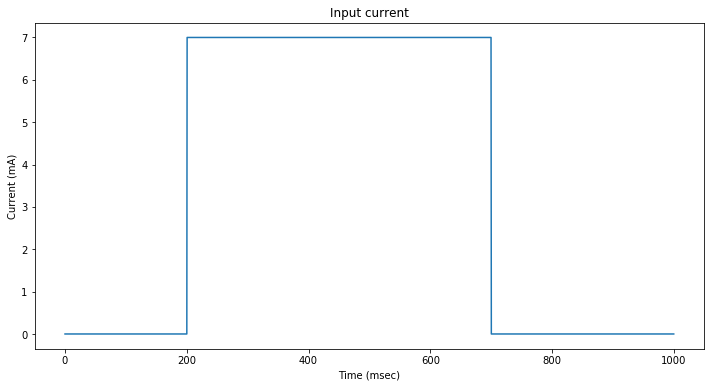

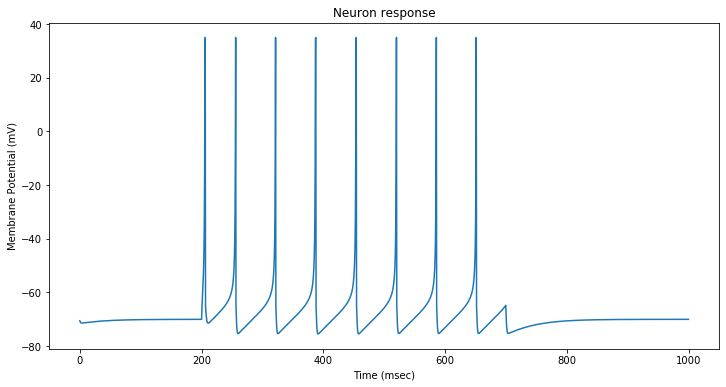

In [16]:
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current and the membrane potential
plt.figure()
plt.title('Input current')
plt.ylabel('Current (mA)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*I_in))
plt.figure()
plt.title('Neuron response')
plt.ylabel('Membrane Potential (mV)')
plt.xlabel('Time (msec)')
plt.plot(*zip(*v_out))

In [12]:

# A class representing a population of simple neurons with synaptic inputs
#
class SimpleSynapticNeurons(SimpleNeurons):
    
    def __init__(self, n=1, m=100, A=None, B=None, C=None, D=None, W_in=None):
        
        # Additional model parameters
        self.m = m
        self.tau = 10.0
        if W_in is None:
            self.W_in = np.full((n,m), 0.07, dtype=np.float32)
        else:
            self.W_in = W_in
        # The reason this one is different is to allow broadcasting when subtracting v
        self.E_in = np.zeros((m), dtype=np.float32)
        
        # Call the parent contructor
        # This will call the methods we have overidden when building the graph 
        super(SimpleSynapticNeurons, self).__init__(n, A, B, C, D)
           
    ########################################################
    # Override the parent graph Variables and placeholders #
    ########################################################    
    def get_vars_and_ph(self):
        
        # Get parent grah variables and placeholders
        super(SimpleSynapticNeurons, self).get_vars_and_ph()
            
        # Input synapse conductance dynamics (increases on each synapse spike)
        self.g_in = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.m]),
                                    dtype=tf.float32,
                                    name='g_in')

        # We need a new placeholder to pass the input synapses behaviour at each timestep
        self.syn_has_spiked = tf.placeholder(tf.bool, shape=[self.m])

        
    #######################################################
    # Modify i_op in the graph of operations:             # 
    #     syn_has_spiked -> g_in_op -> i_op               #
    #######################################################
    def get_input_ops(self, has_fired_op, v_op):

        # First, update synaptic conductance dynamics:
        # - increment by one the current factor of synapses that fired
        # - decrease by tau the conductance dynamics in any case
        g_in_update_op = tf.where(self.syn_has_spiked,
                                  tf.add(self.g_in, tf.ones(shape=self.g_in.shape)),
                                  tf.subtract(self.g_in, tf.multiply(self.dt,tf.divide(self.g_in, self.tau))))

        # Update the g_in variable
        g_in_op = tf.assign(self.g_in, g_in_update_op)

        # We can now evaluate the synaptic input currents
        # Isyn = Σ w_in(j)g_in(j)E_in(j) - (Σ w_in(j)g_in(j)).v(t)
        i_op = tf.subtract(tf.einsum('nm,m->n', tf.constant(self.W_in), tf.multiply(g_in_op, tf.constant(self.E_in))),
                           tf.multiply(tf.einsum('nm,m->n', tf.constant(self.W_in), g_in_op), v_op))

        # Store a reference to this operation for easier retrieval
        self.input = i_op
        
        return i_op

In [13]:
# A class representing a population of simple neurons with synaptic inputs
#
class SimpleSynapticRecurrentNeurons(SimpleSynapticNeurons):
    
    def __init__(self, n=1, m=100, A=None, B=None, C=None, D=None, W_in=None, W=None, E=None):

        # Additional model parameters
        self.W = W
        self.E = E
        
        # Call the parent contructor
        super(SimpleSynapticRecurrentNeurons, self).__init__(n, m, A, B, C, D, W_in)

    ########################################################
    # Override the parent graph Variables and placeholders #
    ########################################################    
    def get_vars_and_ph(self):
        
        # Get parent grah variables and placeholders
        super(SimpleSynapticRecurrentNeurons, self).get_vars_and_ph()
            
        # Recurrent synapse conductance dynamics (increases on each synapse spike)
        self.g = tf.Variable(tf.zeros(dtype=tf.float32, shape=[self.n]),
                             dtype=tf.float32,
                             name='g')

    #######################################################
    # Modify i_op in the graph of operations:             # 
    #     syn_has_spiked -> i_in_op,i_rec_op -> i_op      #
    #######################################################
    def get_input_ops(self, has_fired_op, v_op):

        # First, update recurrent conductance dynamics:
        # - increment by one the current factor of synapses that fired
        # - decrease by tau the conductance dynamics in any case
        g_update_op = tf.where(has_fired_op,
                               tf.add(self.g, tf.ones(shape=self.g.shape)),
                               tf.subtract(self.g, tf.multiply(self.dt, tf.divide(self.g, self.tau))))
        
        # Update the g variable
        g_op = tf.assign(self.g, g_update_op)

        # We can now evaluate the recurrent conductance
        # I_rec = Σ wjgj(Ej -v(t))
        i_rec_op = tf.einsum('ij,j->i', tf.constant(self.W), tf.multiply(g_op, tf.subtract(tf.constant(self.E), v_op)))

        # Get the synaptic input currents from parent
        i_in_op = super(SimpleSynapticRecurrentNeurons, self).get_input_ops(has_fired_op, v_op)
        
        # The actual current is the sum of both currents
        i_op = i_in_op + i_rec_op

        # Store a reference to this operation for easier retrieval
        self.input = i_op
        
        return i_op

In [19]:
##############
# Simulation #
##############
import time
start_time = time.time()



# Duration of the simulation in ms
T = 1000
# Duration of each time step in ms
dt = 0.5
# Number of iterations = T/dt
steps = int(T / dt)
# Number of neurons
n = 8000
# Number of synapses
m = 100
# Synapses firing rate
frate = 0.002

# Array of input current values
I_in = []
# Array of evaluated membrane potential values
v_out = np.zeros((steps,n))
    
# Generate a random distribution for our neurons
p_neurons = np.random.uniform(0,1,(n))
    
# Assign neuron parameters based on the probability
a = np.full((n), 0.02, dtype=np.float32)
a[p_neurons < 0.2] = 0.1
d = np.full((n), 8.0, dtype=np.float32)
d[p_neurons < 0.2] = 2.0

# Randomly connect 10% of the neurons to the input synapses
p_syn = np.random.uniform(0,1,(n,m))
w_in = np.zeros((n,m), dtype=np.float32)
w_in[ p_syn < 0.1 ] = 0.07
    
# Randomly distribute recurrent connections
w = np.zeros((n,n),  dtype=np.float32)
p_reccur = np.random.uniform(0,1,(n,n))
w[p_reccur < 0.1] = np.random.gamma(2, 0.003, size=w[p_reccur < 0.1].shape)
# Identify inhibitory to excitatory connections (receiving end is in row)
inh_2_exc = np.ix_(p_neurons >= 0.2, p_neurons < 0.2)
# Increase the strength of these connections
w[ inh_2_exc ] = 2* w[ inh_2_exc]

# Only inhibitory neurons have E=-85 mv
e = np.zeros((n), dtype=np.float32)
e[p_neurons<0.2] = -85.0

# Instantiate the population of synaptic neurons
neurons = SimpleSynapticRecurrentNeurons(n, m, A=a, D=d, W_in=w_in, W=w, E=e)

with tf.Session(graph=neurons.graph) as sess:

    # Initialize v and u to their default values 
    sess.run(tf.global_variables_initializer())

    # Run the simulation at each time step
    for t in range(steps):
        
        # We generate random spikes on the input synapses between 200 and 700 ms
        if t * dt > 200 and t * dt < 700:
            # Generate a random matrix
            r = np.random.uniform(0,1,(m))
            # A synapse has spiked when r is lower than the spiking rate
            p_syn_spike = r < frate * dt
        else:
            # No synapse activity during that period
            p_syn_spike = np.zeros((m), dtype=bool)
        
        feed = {neurons.syn_has_spiked: p_syn_spike, neurons.dt: [dt]}

        # Run the graph corresponding to our update ops, with our parameters 
        i, v, u = sess.run([neurons.input, neurons.potential, neurons.recovery], feed_dict=feed)
        
        # Store values
        v_out[t, :] = v
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 34.58729887008667 seconds ---


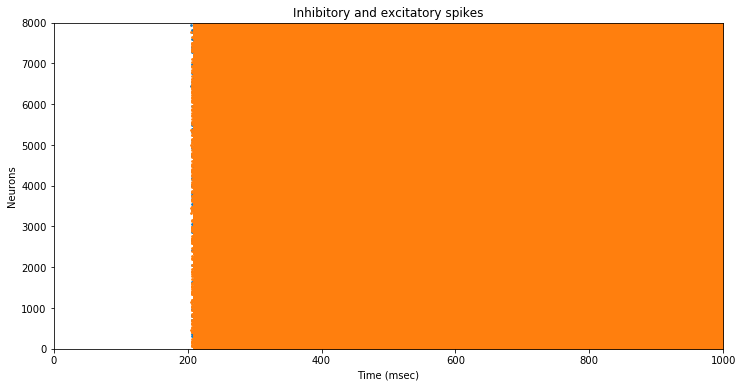

In [18]:
plt.rcParams["figure.figsize"] =(12,6)
# Split between inhibitory and excitatory
inh_v_out = np.where(p_neurons < 0.2, v_out, 0)
exc_v_out = np.where(p_neurons >= 0.2, v_out, 0)
# Identify spikes
inh_spikes = np.argwhere(inh_v_out == 35.0)
exc_spikes = np.argwhere(exc_v_out == 35.0)
# Display spikes over time
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')
plt.ylabel('Neurons')
plt.xlabel('Time (msec)')
# Plot inhibitory spikes
steps, neurons = inh_spikes.T
plt.scatter(steps*dt, neurons, s=3)
# Plot excitatory spikes
steps, neurons = exc_spikes.T
plt.scatter(steps*dt, neurons, s=3)

In [64]:
#=====================
#=====================
class bap_netsim: 
#=====================
#=====================
    """
    Class to build barabasi-albert networks and run avalanche simulations
    dist = distance matrix between all nodes in network
    """

    #========================
    def __init__(self,dist):
    #========================
        import numpy as np
        self.dist = dist
    

    #BUILD NETWORK
    #=================
    #=================
    
    #=====================================
    def sample(self, seq, m):
    #=====================================
        """ Return m unique elements from seq.
        """
        import random
        import numpy as np
        
        #make targets a set - only contains unique elements
        targets=set()
        while len(targets)<m:
            x=random.choice(seq)
            targets.add(x) #add method only adds if x is not already in target set
        return np.array(list(targets))

    
    #=====================================
    def net_generate(self, p, edge_density):
    #=====================================
        """
        Generate Barabasi-Albert preferential attachment network. BA model starts with k initial nodes, and k edges 
        - each new node will connect to k nodes with p(number of edges already connected to each node). 
        
            edge_density = number of edges of each node
            
        """
        
        import numpy as np
        import networkx as nx
        import random
        import copy
        
        prac = nx.powerlaw_cluster_graph(self.dist.shape[0], edge_density, p)
        self.A = nx.to_numpy_array(prac)

        return(self)
    
    
    
    #CALCULATE CYCLES
    #=================
    #=================
    #===========================
    def cycles_calculate(self, edge_density):
    #===========================
        import networkx as nx
        import numpy as np
        
        cyc_mat = self.net_generate(edge_density).A #matrix to calculate cycles
        G = nx.from_numpy_matrix(cyc_mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  int(np.sum(cyc_mat))
        self.cycles = len(cyc)
        self.edges = edge
        return(self)
    
    
    #BUILD WEIGHT MATRIX
    #===================
    #===================
    # Simple sigmoid function to 'soften' the exponential
    #===========================
    def sig(self, x):
    #===========================
        import numpy as np
        self.sig_output = 1 / (1+np.exp(-x))
        return(self)
    
    # Conversion from distance to edge weights, scaled (itself exponentially) by s
    #====================================
    def dist2edge(self, distance, divisor, soften, s):
    #===================================
        import numpy as np
        self.edge_weight_out = np.exp(s/5)*self.sig(np.exp(-soften/np.exp(s)*distance)).sig_output/divisor
        return(self)  
    
    #===========================
    def adjmat_generate(self, s, p, edge_density, divisor, soften):
    #===========================
        import numpy as np
        import copy
        mat = np.zeros((self.dist.shape))
        
        curr_mat = self.net_generate(p, edge_density).A #matrix to calculate cycles
        
        [rows, cols]    = np.where(np.triu(curr_mat) == 1) 
        for e in range(len(rows)):
            edge_weight = self.dist2edge(self.dist[rows[e], cols[e]], divisor, soften, s).edge_weight_out
            mat[rows[e], cols[e]] = edge_weight 
            mat[cols[e], rows[e]] = edge_weight
        self.adj_mat = copy.deepcopy(mat)
            
        return(self)
    
    
    
    #SIMULATE AVALANCHES
    #===================
    #===================
    
    #Find cells to propagate
    #=====================================================
    def propagate_neighbours(self, curr_mat, start_node, r_e):
    #=====================================================
        import numpy as np
        self.prop_nodes = []
        nodes = np.where(curr_mat[start_node] > 0) [0]
        weights = curr_mat[start_node][nodes]
        for f in range(len(nodes)):
            if weights[f] > np.random.uniform(0, 1):
                self.prop_nodes = np.append(self.prop_nodes, nodes[f])
                
        if r_e > np.random.uniform(0,1):
            self.prop_nodes = np.append(self.prop_nodes, start_node)
        return(self)

    
    #Simulate 
    #===========================
    def simulate(self,  s, p, edge_density, max_e, divisor, soften, cutoff, n_sims, iterate):
    #===========================
        import numpy as np
        curr_mat = self.adjmat_generate(s, p, edge_density, divisor, soften).adj_mat
        degree = sum(self.A)
        degree_scaled = (max_e/max(degree)) * degree 
        
        


        
        self.av_size = []
        self.av_dur = []
        
        #iterate simulation calculation for less-noisy distribution
        for x in range(iterate):
            
            for i in range(n_sims):
                #Decide start node
                start_node = np.random.uniform(0, curr_mat.shape[0]-1)
                down = int(start_node)
                up= int(start_node)+1
                if np.random.uniform(down, up) >= start_node:
                    start_node = up
                else:
                    start_node = down


                #Initialise avalanche - ping first node
                t_nodes = self.propagate_neighbours(curr_mat, start_node, degree_scaled[start_node]).prop_nodes #Find connected neighbours > threshold
                curr_list = t_nodes
                iterate = 'yes'

                if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
                    all_nodes = np.append(start_node, t_nodes)
                    timesteps = 1

                    while iterate == 'yes':
                        tplus_nodes = []
                        for z in range(len(curr_list)):
                            #List of all nodes active in next timestep
                            tplus_nodes = np.append(tplus_nodes, self.propagate_neighbours(curr_mat, int(curr_list[z]), degree_scaled[int(curr_list[z])]).prop_nodes)

                        all_nodes = np.append(all_nodes, tplus_nodes)
                        timesteps+=1
                        curr_list = tplus_nodes

                        if len(all_nodes) > cutoff:
                            iterate = 'no'

                        if len(tplus_nodes) == 0: #if no more active cells - stop
                            iterate = 'no'


                    self.av_size = np.append(self.av_size, len(all_nodes)) 
                    self.av_dur = np.append(self.av_dur, timesteps)

                else:
                    continue

        return(self)
    
